# Part2. Model design 2 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
#load the original data
df1=pd.read_csv("../Data/kag_risk_factors_cervical_cancer.csv")

#load the processed datasets:
X_train=pd.read_csv("../Data/X_train_preprocessed.csv")
X_test=pd.read_csv("../Data/X_test_preprocessed.csv")
X_validate=pd.read_csv("../Data/X_validate_preprocessed.csv")
y_train=pd.read_csv("../Data/y_train_preprocessed.csv")
y_test=pd.read_csv("../Data/y_test_preprocessed.csv")
y_validate=pd.read_csv("../Data/y_validate_preprocessed.csv")

In [3]:
#show the processed X_train file:
X_train.tail(2)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
654,-0.587772,-0.879301,-0.001620,-0.137403,0.0,-0.307318,-0.208218,1.0,-0.510729,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
655,0.355828,-0.302480,-1.418945,0.561330,1.0,4.945406,1.145403,0.0,-0.556973,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [4]:
y_train.tail(2)

,Biopsy
654,0
655,1


## Model

The data in unbalanced, let's try to correct the bias:

In [5]:
neg, pos = np.bincount(df1['Biopsy'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 858
    Positive: 55 (6.41% of total)



In [6]:
### Try initializing the model with a bias parameter:

Train the model with and without initial bias and compare outcomes:

In [7]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')]

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [8]:
#initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
#model.save_weights(initial_weights)

In [9]:
#compute an initial bias parameters, to teach the model positive examples are unlikely.
initial_bias = np.log([pos/neg])
initial_bias

array([-2.68102153])

In [10]:
#Uninformed mdoel

model = Sequential() 

#Input layer
model.add(Dense(units=10, 
            input_dim=31, # i have 31 features
            kernel_initializer='uniform', # all features have the same weight
            activation='relu'   
               ))
model.add(Dropout(0.5))  #randomly sets 0.5 units to 0. To prevent overfitting
#Hidden layer 1
model.add(Dense(units=10,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))


#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid'))

#model(output_bias=initial_bias)

print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam',
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])


# Train the model
# Verbose=2, showing loss and accuracy change timely
#remove batch_size, the dataset is small. -> it increases recall.
no_bias_history = model.fit(x=X_train, y=y_train,  
                          validation_split=0.2, epochs=20, verbose=2) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                320       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
17/17 - 0s - loss: 0.6893 - precision: 0.0455 - recall: 0.0278 - accuracy: 0.8931 - val_loss: 0.6840 - val_p

In [11]:
#define the output bias
output_bias = tf.keras.initializers.Constant(initial_bias)
output_bias

In [12]:
#informed model

model = Sequential() 

#Input layer
model.add(Dense(units=10, 
            input_dim=31, # i have 31 features
            kernel_initializer='uniform', # all features have the same weight
            activation='relu'   
               ))
model.add(Dropout(0.5))  #randomly sets 0.5 units to 0. To prevent overfitting
#Hidden layer 1
model.add(Dense(units=10,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))



#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid',
                bias_initializer=output_bias))

#model(output_bias=initial_bias)

print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam',
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])


# Train the model
# Verbose=2, showing loss and accuracy change timely
#remove batch_size, the dataset is small. -> it increases recall.
careful_bias_history = model.fit(x=X_train, y=y_train,  
                          validation_split=0.2, epochs=20, verbose=2) 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
17/17 - 1s - loss: 0.2505 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.9313 - val_loss: 

In [13]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
    colorlist = ["blue", "darkorange"]
    plt.semilogy(history.epoch, history.history['loss'],
               color=colorlist[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colorlist[n], label='Val ' + label,
               linestyle="--")
    
    plt.legend()

    plt.xlabel('Epoch')
    plt.ylabel('Loss')


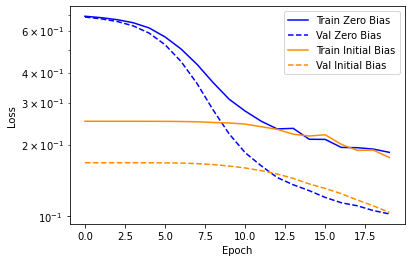

In [14]:
plot_loss(no_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Initial Bias", 1)

### Conclusion, using an initial bias reduces the loss of the model in the first epochs, but the validation loss after 15 epochs is not much different


In [15]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

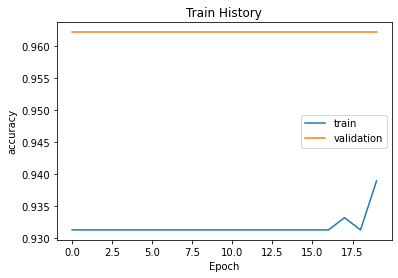

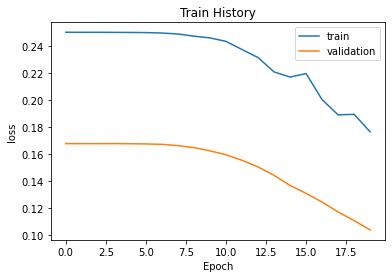

In [16]:
#visualize the loss and accuracy after each epoch
show_train_history(careful_bias_history,'accuracy','val_accuracy')
show_train_history(careful_bias_history,'loss','val_loss')


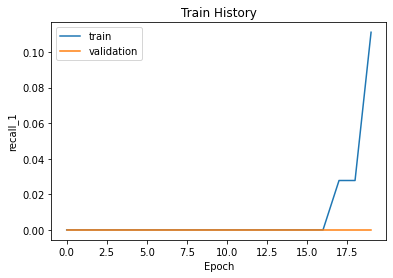

In [17]:
show_train_history(careful_bias_history,'recall_1','val_recall_1')

### The recall in this model is 0. It doesn't predict any cancer cases (of the 9 present)

In [18]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)


In [19]:
p=0.5
cm = confusion_matrix(y_test, test_predictions_baseline > p)


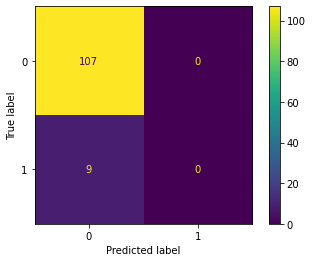

In [20]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [21]:
scores = model.evaluate(X_test, y_test)
print('\n')
print('recall=',scores[2])

4/4 [==============================] - 0s 3ms/step - loss: 0.2289 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.9224


recall= 0.0


#### if I run the exact same model (500 units per layer and 3 hidden layers) the "learning" of the model with bias information is not better than the uninformed model. Not a really good trick here.

In [22]:
# Uninformed complete model:


model = Sequential() 

#Input layer
model.add(Dense(units=500, 
            input_dim=31, # I have 31 features
            kernel_initializer='uniform', # all features have the same weight
            activation='relu'
               ))
model.add(Dropout(0.5))  #randomly sets 0.5 units to 0. To prevent overfitting
#Hidden layer 1
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 2
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 3
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid'))


print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam',
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])


# Train the model
# Verbose=2, showing loss and accuracy change timely
#remove batch_size, the dataset is small. ->  training the network with the whole ds increases recall.
train_history_unbiased = model.fit(x=X_train, y=y_train,  
                          validation_split=0.2, epochs=20, verbose=2) 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 500)               16000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)              

In [23]:
#Complete model with bias information:

model = Sequential() 

#Input layer
model.add(Dense(units=500, 
            input_dim=31, # I have 31 features
            kernel_initializer='uniform', # all features have the same weight
            activation='relu'
               ))
model.add(Dropout(0.5))  #randomly sets 0.5 units to 0. To prevent overfitting
#Hidden layer 1
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 2
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 3
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid',
                bias_initializer=output_bias))


print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam',
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])


# Train the model
# Verbose=2, showing loss and accuracy change timely
#remove batch_size, the dataset is small. ->  training the network with the whole ds increases recall.
train_history_biased = model.fit(x=X_train, y=y_train,  
                          validation_split=0.2, epochs=20, verbose=2) 


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 500)               16000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)              

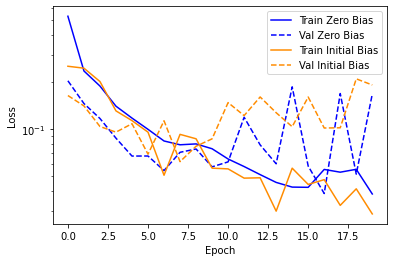

In [24]:
plot_loss(train_history_unbiased, "Zero Bias", 0)
plot_loss(train_history_biased, "Initial Bias", 1)

### When a more complex model is used, the bias advantatge is lost, even with less epochs

### Let's try something different in "cervix_project_2_Model_design_3"